## Setup

In [1]:
import json
from pathlib import Path
from typing import Any, Literal, NamedTuple

import pandas as pd
import torch
from datasets import Array3D, ClassLabel, Dataset, DatasetInfo, Features, Sequence, Value
from pandas.core.groupby import DataFrameGroupBy
from tables import open_file
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and assembling the data

In [2]:
data_dir = (Path(".").absolute().parents[1] / "generated-dataset-30_000" / "data").absolute()
target_data_repo = "dasyd/time-qa"

len(list(data_dir.iterdir()))

30000

In [3]:
class Sample(NamedTuple):
    sample_id: int
    question_id: int
    trajectory: torch.Tensor
    action_sequence: dict[str, Any]
    textual_description: str
    question_type: str
    question: str
    answer_type: str
    answer: str
    options: dict[str, str | bool] | None
    correct_option: str


def get_for(num: int):
    path = data_dir / str(num)
    with open_file(path / "data.hdf5", "r") as hdf5_file:
        trajectory = hdf5_file.root["joints"][:].astype("float32")

    with open(path / "data.json") as json_file:
        data = json.load(json_file)

    return [
        Sample(
            sample_id=num,
            question_id=question_id,
            trajectory=trajectory,
            action_sequence=data["prompt_sequence"],
            textual_description=data["textual_description"],
            question_type=qa_pair["question_type"],
            question=qa_pair["question"],
            answer_type=qa_pair["answer_type"],
            answer=qa_pair["answer"],
            options=qa_pair["options"],  # can be None
            correct_option=qa_pair["correct_option"],
        )
        for question_id, qa_pair in enumerate(data["qa_pairs"])
    ]


next(iter(get_for(0)))

Sample(sample_id=0, question_id=0, trajectory=array([[[-0.00000000e+00,  0.00000000e+00,  9.09141839e-01],
        [-6.73839003e-02, -1.13063212e-02,  8.16436648e-01],
        [ 6.98262751e-02, -8.76581483e-03,  8.20429444e-01],
        ...,
        [-5.63857369e-02,  2.95840979e-01,  1.08185232e+00],
        [-1.95679709e-01,  3.54562610e-01,  1.12341833e+00],
        [-8.76303613e-02,  3.39472294e-01,  1.14494324e+00]],

       [[-9.72520793e-04,  1.18049706e-04,  9.08327520e-01],
        [-6.81914911e-02, -1.18271094e-02,  8.15596581e-01],
        [ 6.89940304e-02, -8.21818504e-03,  8.19674790e-01],
        ...,
        [-6.35459647e-02,  2.98328400e-01,  1.08401477e+00],
        [-2.01585114e-01,  3.54287565e-01,  1.12665832e+00],
        [-9.66204032e-02,  3.39788049e-01,  1.14728212e+00]],

       [[-2.06503086e-03,  3.45450622e-04,  9.07579184e-01],
        [-6.90820739e-02, -1.23296324e-02,  8.14801037e-01],
        [ 6.80631101e-02, -7.62050971e-03,  8.19016635e-01],
        .

In [4]:
# Sorting is important for reproducibility
all_ids = sorted([int(path.name) for path in data_dir.glob("*") if (path / "data.hdf5").exists()])

# Some file may only be partially written, we ignore them
for num in tqdm(all_ids[:]):
    try:
        with open_file(data_dir / str(num) / "data.hdf5", "r") as hdf5_file:
            hdf5_file.root["joints"]
    except Exception:
        print(f"Error in {num}, ignoring! (This should never occur outside of debugging.)")
        all_ids.remove(num)

len(all_ids)

100%|██████████| 30000/30000 [00:20<00:00, 1480.20it/s]


30000

In [16]:
splits = ["train", "val", "test"]

# For a predefined split:
# def get_ids_in_split(split: str) -> list[int]:
#     with open(data_dir.parent / f"{split}.json", "r") as json_file:
#         return {entry["org_idx"] for entry in json.load(json_file)}
# ids_in_split = {split: get_ids_in_split(split) for split in splits}

# For a random split:
train = 0.8
val = 0.10
test = 0.10
ids_in_split = {
    "train": sorted(all_ids[: int(train * len(all_ids))]),
    "val": sorted(all_ids[int(train * len(all_ids)) : int((train + val) * len(all_ids))]),
    "test": sorted(all_ids[int((train + val) * len(all_ids)) :]),
}

assert len(all_ids)
assert len(set([*ids_in_split["train"], *ids_in_split["val"], *ids_in_split["test"]])) == len(all_ids)

len(ids_in_split["train"]), len(ids_in_split["val"]), len(ids_in_split["test"])

(24000, 3000, 3000)

In [17]:
# Write the ids to a text file

for split in splits:
    with open(data_dir.parent / f"{split}_ids.txt", "w") as file:
        file.write("\n".join(map(str, ids_in_split[split])))

In [18]:
def make_info(task: Literal["binary", "open", "multi"]):
    base_features = {
        "sample_id": Value("int32"),
        "question_id": Value("int32"),
        "trajectory": Array3D(dtype="float32", shape=next(iter(get_for(0))).trajectory.shape),
        "action_sequence": Sequence(
            Features(
                {
                    "start": Value("float32"),
                    "end": Value("float32"),
                    "action": Value("string"),
                    "action_sentence": Value("string"),
                }
            ),
            length=4,
        ),
        "textual_description": Value("string"),
        "question_type": Value("string"),
        "question": Value("string"),
        "answer_type": Value("string"),
        "answer_text": Value("string"),  # That's the answer in text form, always present
    }

    match task:
        case "binary":
            feat_type = Features(
                base_features | {"answer": ClassLabel(names=["true", "false"], num_classes=2)}
            )

        case "multi":
            feat_type = Features(
                base_features
                | {
                    "answer": ClassLabel(num_classes=3),
                    "options_sequence": Sequence(Value("string"), length=3),
                    "options": Features(
                        {
                            "A": Value("string"),
                            "B": Value("string"),
                            "C": Value("string"),
                        }
                    ),
                }
            )

        case "open":
            feat_type = Features(base_features | {"answer_text": Value("string")})

    return DatasetInfo(features=feat_type)


def get_all(ids: set[int]) -> pd.DataFrame:
    # Using process_map to automatically manage the progress bar with executor.map
    results = process_map(get_for, ids, max_workers=None, chunksize=1, total=len(ids))
    return pd.DataFrame([elem._asdict() for sublist in results for elem in sublist])

In [19]:
def push_grouped_df_to_hub(
    df_group: DataFrameGroupBy,
    split: Literal["test", "val", "train"],
    limit_task: list[Literal["open", "multi", "binary"]],
    token: str = None,
):
    """
    Takes a grouped DataFrame, feature types, dataset info, and a Hugging Face authentication token,
    then pushes each group to the Hugging Face Hub under specified configurations.

    :param df_group: Grouped Pandas DataFrame object.
    :param feat_type: Feature type for the dataset.
    :param info: Information about the dataset.
    :param token: Hugging Face authentication token.
    """
    for name, group in df_group:
        if name not in limit_task:
            continue
        print(f"Group Name: {name}")

        group = group.rename(columns={"answer": "answer_text"})

        match name:
            case "binary":
                group["answer"] = (group["correct_option"] == "A").astype(int)
                group = group.drop(columns=["options"])

            case "multi":
                mapping = {"A": 0, "B": 1, "C": 2}
                group["answer"] = [mapping[option] for option in group["correct_option"]]

                group["options_sequence"] = group["options"].apply(lambda x: list(x.values()))

            case "open":
                group = group.drop(columns=["options"])

        group = group.drop(columns=["correct_option"])

        lst_dict = group.to_dict(orient="records")

        info = make_info(name)

        # Create a dataset from the list of dictionaries and push it to the hub
        dataset = Dataset.from_list(lst_dict, info=info, split=split)
        dataset.push_to_hub(
            target_data_repo,
            config_name=name,
            token=token,
            split=split,
        )

        print(f"Pushed to huggingface: {target_data_repo}/{split}/{name}")

## Persisting the dataset

You have to first run:

```shell
huggingface-cli login
```

In [21]:
splits = ["val", "test", "train"]

for s in splits:
    _df = get_all(ids_in_split[s])
    _df_group = _df.groupby("answer_type")

    push_grouped_df_to_hub(_df_group, split=s, limit_task=["binary", "multi", "open"])

100%|██████████| 3000/3000 [00:01<00:00, 1634.82it/s]


Group Name: binary


Uploading the dataset shards: 100%|██████████| 2/2 [00:30<00:00, 15.18s/it]


Pushed to huggingface: dasyd/time-qa/val/binary
Group Name: multi


Uploading the dataset shards: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]


Pushed to huggingface: dasyd/time-qa/val/multi
Group Name: open


Uploading the dataset shards: 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


Pushed to huggingface: dasyd/time-qa/val/open


100%|██████████| 3000/3000 [00:01<00:00, 1653.68it/s]


Group Name: binary


Uploading the dataset shards: 100%|██████████| 2/2 [00:22<00:00, 11.10s/it]


Pushed to huggingface: dasyd/time-qa/test/binary
Group Name: multi


Uploading the dataset shards: 100%|██████████| 2/2 [00:17<00:00,  8.65s/it]


Pushed to huggingface: dasyd/time-qa/test/multi
Group Name: open


Uploading the dataset shards: 100%|██████████| 2/2 [00:15<00:00,  7.92s/it]


Pushed to huggingface: dasyd/time-qa/test/open


100%|██████████| 24000/24000 [00:14<00:00, 1611.45it/s]


Group Name: binary


Uploading the dataset shards: 100%|██████████| 13/13 [02:59<00:00, 13.77s/it]


Pushed to huggingface: dasyd/time-qa/train/binary
Group Name: multi


Uploading the dataset shards: 100%|██████████| 9/9 [02:13<00:00, 14.88s/it]


Pushed to huggingface: dasyd/time-qa/train/multi
Group Name: open


Uploading the dataset shards: 100%|██████████| 9/9 [02:09<00:00, 14.39s/it]


Pushed to huggingface: dasyd/time-qa/train/open


## Test if it works (this re-downloads the dataset)

In [49]:
from typing import Literal

from datasets import VerificationMode, concatenate_datasets, load_dataset
from lightning.pytorch import LightningDataModule
from torch.utils.data import DataLoader


class TimeQADataModule(LightningDataModule):
    def __init__(
        self,
        task: Literal["binary", "multi", "open"],
        batch_size: int = 32,
        repo: str = target_data_repo,
    ):
        super().__init__()

        self.task = task
        self.batch_size = batch_size
        self.repo = repo

    def _load_dataset_split(self, splits: list[str]):
        """Workaround to overcome the missing hf implementation of only dowloading the split shards"""
        dataset = load_dataset(
            self.repo,
            self.task,
            data_dir=self.task,
            data_files={split: f"{split}-*" for split in splits},
            verification_mode=VerificationMode.NO_CHECKS,
            num_proc=len(splits),
        )
        dataset.set_format(type="torch", columns=["trajectory"], output_all_columns=True)
        return dataset

    def prepare_data(self) -> None:
        # Download all, since only this is run on the main process
        self._load_dataset_split(["train", "val", "test"])

    def setup(self, stage: str) -> None:
        if stage == "fit":
            self.dataset = self._load_dataset_split(["train", "val"])
        elif stage == "test":
            self.dataset = self._load_dataset_split(["test"])

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.dataset["train"], batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.dataset["val"], batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.dataset["test"], batch_size=self.batch_size)

    def all_splits(self) -> Dataset:
        return concatenate_datasets(self._load_dataset_split(["train", "val", "test"]).values())


module = TimeQADataModule(task="multi", batch_size=64)
module.prepare_data()
module.setup("fit")
# module.setup("test")

In [50]:
loader = module.val_dataloader()
batch = next(iter(loader))
list(batch.keys())

['trajectory',
 'sample_id',
 'question_id',
 'action_sequence',
 'textual_description',
 'question_type',
 'question',
 'answer_type',
 'answer_text',
 'options',
 'answer',
 'options_sequence']

In [51]:
# batch

In [52]:
batch["trajectory"].shape

torch.Size([64, 320, 24, 3])

In [53]:
len(batch["action_sequence"]["action"])

4

In [54]:
len_action = batch["trajectory"].shape[1] // len(batch["action_sequence"]["action"])
len_action

80

In [55]:
df = pd.DataFrame.from_dict(
    {
        "batch_index": batch_idx,
        "action_idx": action_idx,
        "action": batch["action_sequence"]["action"][action_idx][batch_idx],
        "time_step": time_step,
        "values": values,
    }
    for batch_idx in range(batch["trajectory"].shape[0])
    for action_idx in range(len(batch["action_sequence"]["action"]))
    for time_step, values in enumerate(
        batch["trajectory"][batch_idx, action_idx * len_action : (action_idx + 1) * len_action, ...]
        .flatten(start_dim=1)
        .numpy()
    )
)
df

,batch_index,action_idx,action,time_step,values
0,0,0,holding a baby,0,"[-0.0, -0.0, 0.89534616, -0.06452019, -0.00502..."
1,0,0,holding a baby,1,"[-0.0022204476, -0.0010429027, 0.89410174, -0...."
2,0,0,holding a baby,2,"[-0.004288206, -0.0014186944, 0.89302117, -0.0..."
3,0,0,holding a baby,3,"[-0.006342059, -0.0014529098, 0.8925396, -0.07..."
4,0,0,holding a baby,4,"[-0.008368803, -0.0012679921, 0.89239055, -0.0..."
...,...,...,...,...,...
20475,63,3,drinking with the left hand,75,"[-0.007374956, -0.28087932, 0.9086406, -0.0787..."
20476,63,3,drinking with the left hand,76,"[-0.0075493543, -0.28136778, 0.9088956, -0.078..."
20477,63,3,drinking with the left hand,77,"[-0.0076767886, -0.28172055, 0.909219, -0.0790..."
20478,63,3,drinking with the left hand,78,"[-0.00777553, -0.2819359, 0.909377, -0.0790569..."


In [59]:
# df_fine = df.explode("values")

df_fine = df.copy()
variate = 61
df_fine["values"] = df_fine["values"].apply(lambda x: x[variate])

df_fine

,batch_index,action_idx,action,time_step,values
0,0,0,holding a baby,0,0.287024
1,0,0,holding a baby,1,0.283906
2,0,0,holding a baby,2,0.281320
3,0,0,holding a baby,3,0.278425
4,0,0,holding a baby,4,0.274913
...,...,...,...,...,...
20475,63,3,drinking with the left hand,75,-0.236824
20476,63,3,drinking with the left hand,76,-0.233851
20477,63,3,drinking with the left hand,77,-0.230811
20478,63,3,drinking with the left hand,78,-0.227605


In [60]:
df_fine["action"].nunique()

19

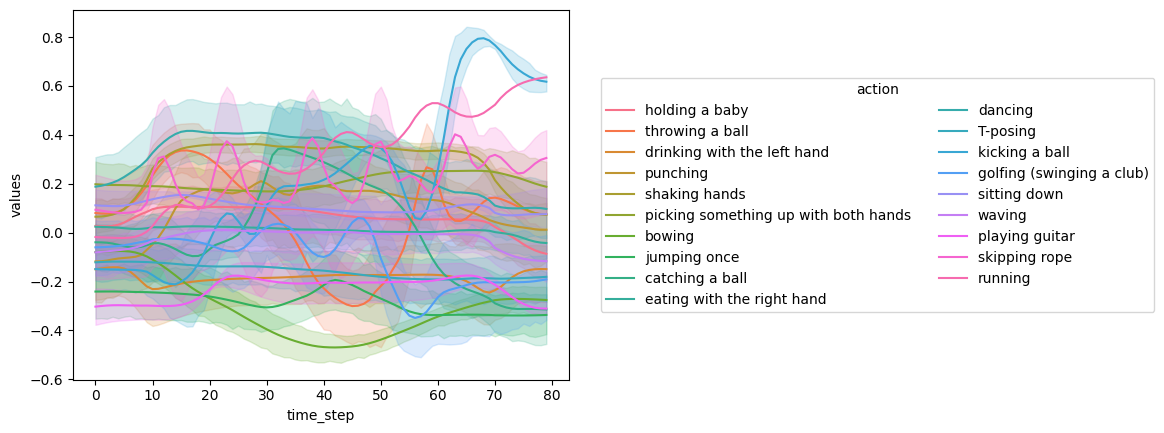

In [61]:
import seaborn as sns

ax = sns.lineplot(
    data=df_fine,
    x="time_step",
    y="values",
    hue="action",
)
sns.move_legend(ax, loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2)